# A. Data Wrangling

# 1. Purpose of This Data Science Project

The purpose of this data science project is to develop a pricing model for rents listed on rental postings. Property owners would benefit from listing their property at an appropriate price and in line with their position in the market. Owners would also benefit from insights to high-value versus low-value features.

# 2. Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
pd.options.display.max_columns = None
import missingno as msno
import pandas_profiling
from pandas_profiling.utils.cache import cache_file
from collections import defaultdict
from datetime import datetime
from fuzzywuzzy import process, fuzz
import itertools

C:\Users\zebin\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# 3. Objectives of This Notebook

- To determine if the data we have could be use to develop a pricing model
    - Verify that there is an appropriate target feature
    - Verify that there are potentially useful features
- Verify that there are not fundamental issues with the data

# 4. Loading Data

In [2]:
immo_data= pd.read_csv('../data/raw/immo_data.csv')

In [3]:
rentals = immo_data.copy()

In [4]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomTvOffer            236231 non-null  object 
 4   telekomHybridUploadSpeed  45020 non-null   float64
 5   newlyConst                268850 non-null  bool   
 6   balcony                   268850 non-null  bool   
 7   picturecount              268850 non-null  int64  
 8   pricetrend                267018 non-null  float64
 9   telekomUploadSpeed        235492 non-null  float64
 10  totalRent                 228333 non-null  float64
 11  yearConstructed           211805 non-null  float64
 12  scoutId                   268850 non-null  int64  
 13  noParkSpaces              93052 non-null   f

In [5]:
rentals.head()

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,840.0,1965.0,96107057,1.0,oil,False,Nordrhein_Westfalen,True,2.0,595.0,244,86.00,Dortmund,well_kept,normal,NaN,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,False,4,ground_floor,44269,4.0,181.4,1.0,3.0,4,True,4,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,NaN,1871.0,111378734,2.0,gas,False,Rheinland_Pfalz,False,1.0,800.0,NaN,89.00,Rhein_Pfalz_Kreis,refurbished,normal,no,no_information,NaN,False,5,ground_floor,67459,3.0,NaN,NaN,NaN,3,False,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,NaN,2019.0,NaN,NaN,May19
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.0,True,True,8,2.72,2.4,1300.0,2019.0,113147523,1.0,NaN,False,Sachsen,True,9.0,965.0,4,83.80,Dresden,first_time_use,sophisticated,NaN,Turnerweg,Turnerweg,True,6,apartment,1097,3.0,NaN,3.0,4.0,3,False,4,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaN,NaN,NaN,NaN,Oct19
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,NaN,False,True,9,1.53,40.0,NaN,1964.0,108890903,NaN,district_heating,False,Sachsen,False,2.0,343.0,35,58.15,Mittelsachsen_Kreis,NaN,NaN,NaN,Gl&uuml;ck-Auf-Stra&szlig;e,Glück-Auf-Straße,False,2,other,9599,3.0,86.0,3.0,NaN,3,False,2,Mittelsachsen_Kreis,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,87.23,NaN,NaN,NaN,NaN,May19
4,Bremen,138.00,self_contained_central_heating,NaN,NaN,False,True,19,2.46,NaN,903.0,1950.0,114751222,NaN,gas,False,Bremen,False,1.0,765.0,10,84.97,Bremen,refurbished,NaN,NaN,Hermann-Henrich-Meier-Allee,Hermann-Henrich-Meier-Allee,False,5,apartment,28213,3.0,188.9,1.0,NaN,3,False,4,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaN,NaN,NaN,NaN,Feb20


# 5. Explore Data

## 5.1 Datetime Features

- We observed that certain features were dates. We will convert these features to a datetime format

In [6]:
#Convert yearConstructed, lastRefurbish and date to datetime
rentals.yearConstructed = pd.to_datetime(rentals.yearConstructed, format = '%Y', errors = 'coerce')
rentals.lastRefurbish = pd.to_datetime(rentals.lastRefurbish, format = '%Y', errors = 'coerce')
rentals.date = pd.to_datetime(rentals.date, format = '%b%y')

In [7]:
#Verify datetime features
rentals.select_dtypes(include=[np.datetime64]).head(3)

,yearConstructed,lastRefurbish,date
0,1965-01-01,NaT,2019-05-01
1,1871-01-01,2019-01-01,2019-05-01
2,2019-01-01,NaT,2019-10-01


## 5.2 Crossfield Validation of Price-related Features 

- Data owner noted that totalRent was the sum of baseRent, serviceCharge and heatingCosts. Let us review these features to determine which rows adhere to this formula

In [8]:
#Create new crossfield validation features and specify variable with price and crossfield validation features
rentals['crossfield_service'] = rentals.baseRent + rentals.serviceCharge
rentals['crossfield_heating'] = rentals.baseRent + rentals.heatingCosts
rentals['crossfield_all'] = rentals.baseRent + rentals.serviceCharge + rentals.heatingCosts
crossfields = ['baseRent','serviceCharge', 'heatingCosts','crossfield_service', \
               'crossfield_heating','crossfield_all', 'totalRent']
rentals[crossfields].sample(10)

,baseRent,serviceCharge,heatingCosts,crossfield_service,crossfield_heating,crossfield_all,totalRent
188241,963.80,300.0,NaN,1263.80,NaN,NaN,NaN
114355,630.00,190.0,NaN,820.00,NaN,NaN,820.00
188825,576.00,180.0,NaN,756.00,NaN,NaN,576.00
140605,391.00,119.0,34.0,510.00,425.00,544.00,544.00
3931,600.00,120.0,NaN,720.00,NaN,NaN,720.00
122185,298.00,80.0,60.0,378.00,358.00,438.00,438.00
88862,750.00,400.0,NaN,1150.00,NaN,NaN,NaN
256041,449.00,115.0,NaN,564.00,NaN,NaN,564.00
183372,810.00,200.0,NaN,1010.00,NaN,NaN,1010.00
126145,322.88,50.0,51.0,372.88,373.88,423.88,423.88


In [9]:
'''Use np.select to allocate the value of a crossfield feature to a new feature if the 
    crossfield has the same value as the total rent'''
conditions = [rentals.totalRent == rentals.baseRent, rentals.totalRent == rentals.crossfield_service, \
              rentals.totalRent == rentals.crossfield_heating, rentals.totalRent == rentals.crossfield_all]
choices = [rentals.baseRent, rentals.crossfield_service, rentals.crossfield_heating, rentals.crossfield_all]
rentals['cf_validation'] = np.select(conditions, choices, default = np.nan)

In [10]:
#Specify a variable to display partial dataframe with crossfield and price-related information
valCrossfields = ['baseRent','serviceCharge', 'heatingCosts','crossfield_service', \
               'crossfield_heating','crossfield_all','cf_validation', 'totalRent']

In [11]:
#View new cf_validation variable with non-null entries
rentals.loc[rentals.cf_validation.notnull(), valCrossfields].head()

,baseRent,serviceCharge,heatingCosts,crossfield_service,crossfield_heating,crossfield_all,cf_validation,totalRent
0,595.00,245.0,NaN,840.00,NaN,NaN,840.00,840.00
4,765.00,138.0,NaN,903.00,NaN,NaN,903.00,903.00
6,310.00,70.0,NaN,380.00,NaN,NaN,380.00,380.00
7,452.25,88.0,44.0,540.25,496.25,584.25,584.25,584.25
8,580.00,110.0,NaN,690.00,NaN,NaN,690.00,690.00


In [12]:
#Determine number of listings without a cf_validation entry
rentals.cf_validation.isnull().sum()

67533

In [13]:
#View null cf_valiation entries where totalRent is non-null
rentals.loc[rentals.cf_validation.isnull() & rentals.totalRent.notnull(), valCrossfields]. \
            sort_values(by = 'totalRent', ascending = False).head(20)

,baseRent,serviceCharge,heatingCosts,crossfield_service,crossfield_heating,crossfield_all,cf_validation,totalRent
239533,1325.00,250.00,NaN,1575.00,NaN,NaN,NaN,15751535.00
109047,950.00,200.00,NaN,1150.00,NaN,NaN,NaN,1150900.00
79903,350.00,135.00,NaN,485.00,NaN,NaN,NaN,485350.00
23490,820.00,260.00,NaN,1080.00,NaN,NaN,NaN,108000.00
197378,487.51,159.00,NaN,646.51,NaN,NaN,NaN,64651.00
16832,460.29,171.75,NaN,632.04,NaN,NaN,NaN,63204.00
97927,427.70,50.00,38.0,477.70,465.7,515.7,NaN,51570.00
240954,266.00,110.00,NaN,376.00,NaN,NaN,NaN,37600.00
50706,184.00,11.19,NaN,195.19,NaN,NaN,NaN,19519.00
57237,13000.00,1550.00,NaN,14550.00,NaN,NaN,NaN,15000.00


- We note that the top 9 values for total rent are mistakes having to do with misplaced decimal points. We will replace them with their appropriate crossfield validation entries.

In [14]:
#Define indexes to change
indexes = [239533, 109047, 79903, 23490, 197378, 16832, 97927, 240954, 50706]

In [15]:
#View indexes
rentals.loc[indexes, valCrossfields]

,baseRent,serviceCharge,heatingCosts,crossfield_service,crossfield_heating,crossfield_all,cf_validation,totalRent
239533,1325.00,250.00,NaN,1575.00,NaN,NaN,NaN,15751535.0
109047,950.00,200.00,NaN,1150.00,NaN,NaN,NaN,1150900.0
79903,350.00,135.00,NaN,485.00,NaN,NaN,NaN,485350.0
23490,820.00,260.00,NaN,1080.00,NaN,NaN,NaN,108000.0
197378,487.51,159.00,NaN,646.51,NaN,NaN,NaN,64651.0
16832,460.29,171.75,NaN,632.04,NaN,NaN,NaN,63204.0
97927,427.70,50.00,38.0,477.70,465.7,515.7,NaN,51570.0
240954,266.00,110.00,NaN,376.00,NaN,NaN,NaN,37600.0
50706,184.00,11.19,NaN,195.19,NaN,NaN,NaN,19519.0


In [16]:
#Define their respective crossfield values
values = [1575.00, 1150.00, 485.00, 1080.00, 646.51, 632.04, 477.70, 376.00, 195.19]
pairs = zip(indexes, values)

In [17]:
#Replace total rent with the crossfield values and update cf_validation
for idx, value in pairs:
    rentals.loc[[idx], 'totalRent'] = value
    rentals.loc[[idx], 'cf_validation'] = value
rentals.loc[indexes, valCrossfields]

,baseRent,serviceCharge,heatingCosts,crossfield_service,crossfield_heating,crossfield_all,cf_validation,totalRent
239533,1325.00,250.00,NaN,1575.00,NaN,NaN,1575.00,1575.00
109047,950.00,200.00,NaN,1150.00,NaN,NaN,1150.00,1150.00
79903,350.00,135.00,NaN,485.00,NaN,NaN,485.00,485.00
23490,820.00,260.00,NaN,1080.00,NaN,NaN,1080.00,1080.00
197378,487.51,159.00,NaN,646.51,NaN,NaN,646.51,646.51
16832,460.29,171.75,NaN,632.04,NaN,NaN,632.04,632.04
97927,427.70,50.00,38.0,477.70,465.7,515.7,477.70,477.70
240954,266.00,110.00,NaN,376.00,NaN,NaN,376.00,376.00
50706,184.00,11.19,NaN,195.19,NaN,NaN,195.19,195.19


In [18]:
rentals['cf_validation'] = np.select(conditions, choices, default = np.nan)

In [19]:
rentals.loc[rentals.cf_validation.isnull() & rentals.totalRent.notnull(), valCrossfields]. \
            sort_values(by = 'totalRent', ascending = False).head(20)

,baseRent,serviceCharge,heatingCosts,crossfield_service,crossfield_heating,crossfield_all,cf_validation,totalRent
57237,13000.0,1550.00,NaN,14550.00,NaN,NaN,NaN,15000.00
209250,1050.0,180.00,70.0,1230.00,1120.0,1300.0,NaN,13500.00
38143,10500.0,2000.00,NaN,12500.00,NaN,NaN,NaN,11900.00
255251,1050.0,200.00,100.0,1250.00,1150.0,1350.0,NaN,11250.00
65562,9500.0,760.00,NaN,10260.00,NaN,NaN,NaN,9774.00
214772,6580.0,780.00,NaN,7360.00,NaN,NaN,NaN,8780.00
9055,8700.0,405.00,245.0,9105.00,8945.0,9350.0,NaN,8706.00
101948,6109.0,690.00,NaN,6799.00,NaN,NaN,NaN,8124.00
201485,5680.0,1665.00,NaN,7345.00,NaN,NaN,NaN,7745.00
204189,5800.0,1739.56,NaN,7539.56,NaN,NaN,NaN,7539.56


## 5.3 Reviewing Data Completeness

In [20]:
#To determine counts and percentage of valid entries
missing = pd.concat([rentals.isnull().sum(), rentals.isnull().mean() * 100], axis = 1)
missing.columns = ['num_mssg', 'pct_mssg']
missing.sort_values(by = 'num_mssg', ascending = False)

,num_mssg,pct_mssg
telekomHybridUploadSpeed,223830,83.254603
electricityBasePrice,222004,82.575414
electricityKwhPrice,222004,82.575414
energyEfficiencyClass,191063,71.066766
lastRefurbish,188145,69.981402
crossfield_all,183545,68.270411
crossfield_heating,183332,68.191185
heatingCosts,183332,68.191185
noParkSpaces,175798,65.388879
petsAllowed,114573,42.615957


- Let's view the completeness count and fraction of bottom twenty features

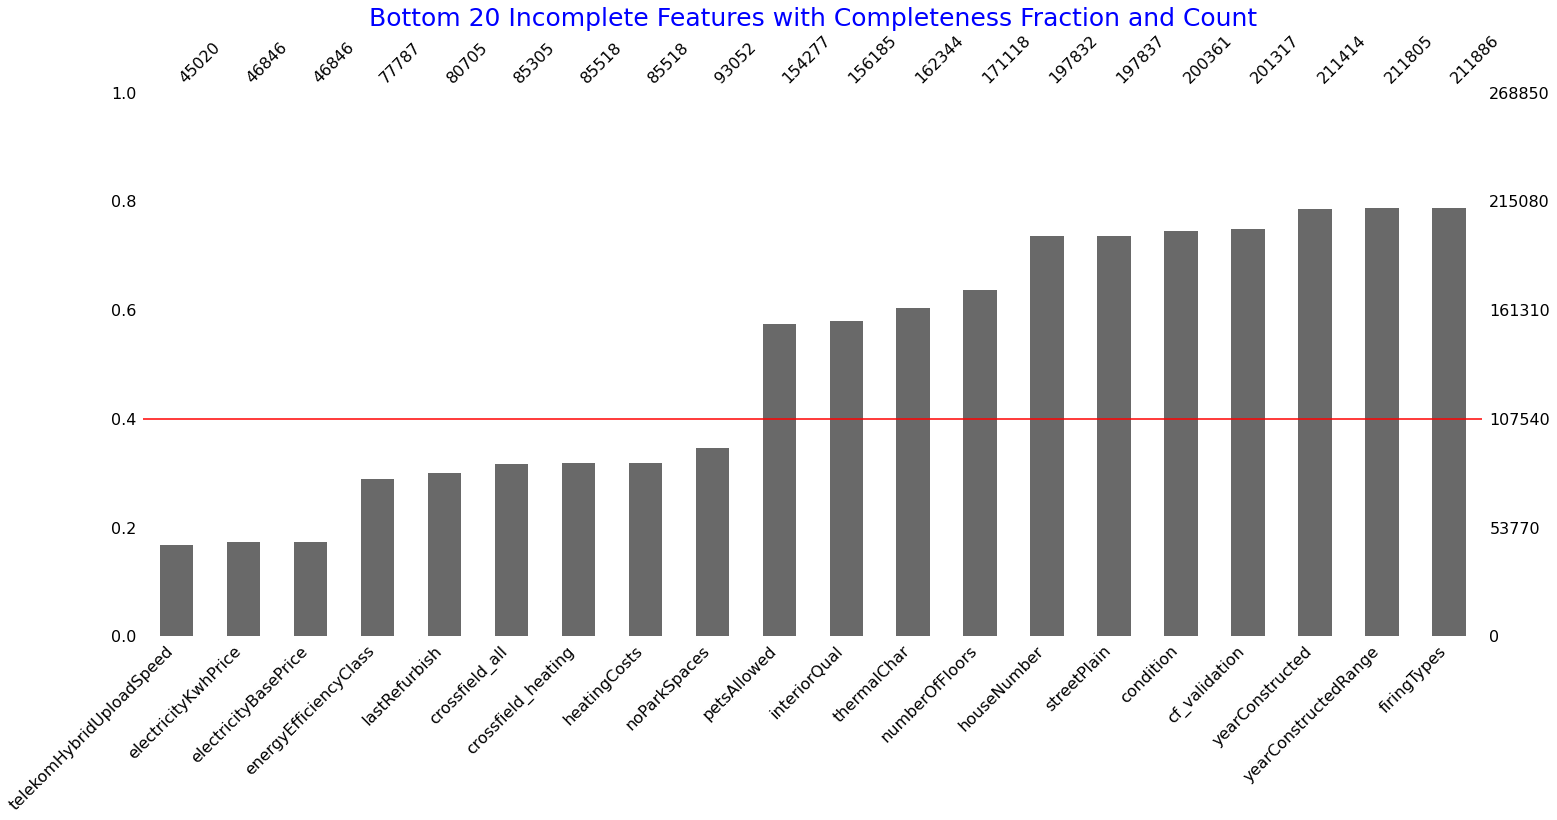

In [21]:
_= msno.bar(rentals,filter = 'bottom', n = 20, sort = 'ascending')
_= plt.axhline(y=0.4, color='r', linestyle='-')
_= plt.title('Bottom 20 Incomplete Features with Completeness Fraction and Count', fontsize = 25, color = 'blue')

- There are seven features that are less than 40% complete, including heatingCosts and electricityKwhPrice. We will filter-out these features from the dataframe.

In [22]:
#Filter-out features with over 40% missing values
rentals = msno.nullity_filter(rentals,filter = 'top', p =0.4)
rentals.shape

(268850, 44)

## 5.4 Checking for Duplicated Rental Units 

In [23]:
#Check for duplicates across all columns except scoutId which is the unique identifier for each listing
rentals_noScoutId = rentals.loc[:, rentals.columns != 'scoutId']
duplicates = rentals_noScoutId.duplicated()
duplicates.sum()

899

-There are potentially 900 duplicated rows. We will review the nature of the duplicated rows

In [24]:
subset = ['houseNumber', 'streetPlain','regio3', 'regio2','regio1','geo_plz', 'baseRent', 'totalRent', 'noRooms']
full_duplicates = rentals_noScoutId.duplicated(keep = False)
rentals.loc[full_duplicates, subset].sort_values(by = ['regio3', 'streetPlain']).head(20)

,houseNumber,streetPlain,regio3,regio2,regio1,geo_plz,baseRent,totalRent,noRooms
122607,NaN,NaN,Aachen_Eilendorf,Aachen,Nordrhein_Westfalen,52080,650.00,NaN,3.0
135689,NaN,NaN,Aachen_Eilendorf,Aachen,Nordrhein_Westfalen,52080,650.00,NaN,3.0
54879,NaN,NaN,Abensberg,Kelheim_Kreis,Bayern,93326,600.00,750.00,2.0
226122,NaN,NaN,Abensberg,Kelheim_Kreis,Bayern,93326,600.00,750.00,2.0
25677,27,Dörpfeldstraße,Adlershof_Treptow,Berlin,Berlin,12489,1330.00,1710.00,5.0
86827,5,Dörpfeldstraße,Adlershof_Treptow,Berlin,Berlin,12489,621.35,763.05,1.0
207406,5,Dörpfeldstraße,Adlershof_Treptow,Berlin,Berlin,12489,621.35,763.05,1.0
235965,27,Dörpfeldstraße,Adlershof_Treptow,Berlin,Berlin,12489,1330.00,1710.00,5.0
267457,27,Dörpfeldstraße,Adlershof_Treptow,Berlin,Berlin,12489,1330.00,1710.00,5.0
26652,NaN,NaN,Adlershof_Treptow,Berlin,Berlin,12489,600.00,700.00,2.0


- We will drop duplicated rows

In [25]:
column_names = rentals.loc[:, rentals.columns != 'scoutId'].columns

In [26]:
rentals.shape

(268850, 44)

In [27]:
rentals.drop_duplicates(subset = column_names, inplace = True)
rentals.shape

(267951, 44)

## 5.5 Reviewing Categorical Features
    
### 5.5.1 Address Information <br>(houseNumber, geo_bln, geo_krs, street, geo_plz, regio1, regio2,    regio3, streetPlain)</br>

In [28]:
address = ['houseNumber','street', 'streetPlain', 'regio3', 'regio2','geo_krs','regio1', 'geo_bln', 'geo_plz']
rentals[address].head()

,houseNumber,street,streetPlain,regio3,regio2,geo_krs,regio1,geo_bln,geo_plz
0,244,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,Schüren,Dortmund,Dortmund,Nordrhein_Westfalen,Nordrhein_Westfalen,44269
1,NaN,no_information,NaN,Böhl_Iggelheim,Rhein_Pfalz_Kreis,Rhein_Pfalz_Kreis,Rheinland_Pfalz,Rheinland_Pfalz,67459
2,4,Turnerweg,Turnerweg,Äußere_Neustadt_Antonstadt,Dresden,Dresden,Sachsen,Sachsen,1097
3,35,Gl&uuml;ck-Auf-Stra&szlig;e,Glück-Auf-Straße,Freiberg,Mittelsachsen_Kreis,Mittelsachsen_Kreis,Sachsen,Sachsen,9599
4,10,Hermann-Henrich-Meier-Allee,Hermann-Henrich-Meier-Allee,Neu_Schwachhausen,Bremen,Bremen,Bremen,Bremen,28213


- We notice that street seems identical to streetPlain, regio2 seems identical to geo_krs and regio1 seems identical to geo_bln
- We will review these relationships

In [29]:
#Check if there are records where regio1 is not identical to geo_bln 
(rentals["regio1"] != rentals['geo_bln']).sum() 

0

- regio1 is the state and it is always equal to geo_bln. We will drop geo_bln

In [30]:
#Number of categories
rentals.regio1.nunique()

16

In [31]:
#Review category names and how many records in which they appear
rentals.regio1.value_counts()

Nordrhein_Westfalen       62744
Sachsen                   57848
Bayern                    21566
Sachsen_Anhalt            20049
Hessen                    17744
Niedersachsen             16564
Baden_Württemberg         16058
Berlin                    10353
Thüringen                  8363
Rheinland_Pfalz            8351
Brandenburg                6921
Schleswig_Holstein         6640
Mecklenburg_Vorpommern     6624
Hamburg                    3741
Bremen                     2960
Saarland                   1425
Name: regio1, dtype: int64

In [32]:
#Check if there are records where regio1 is not identical to geo_bln 
(rentals["regio2"] != rentals['geo_krs']).sum() 

0

- regio2 is the district and it is always equal to geo_krs. We will drop geo_krs

In [33]:
#Number of categories
rentals.regio2.nunique()

419

In [34]:
rentals.regio2.unique()

array(['Dortmund', 'Rhein_Pfalz_Kreis', 'Dresden', 'Mittelsachsen_Kreis',
       'Bremen', 'Schleswig_Flensburg_Kreis', 'Emmendingen_Kreis',
       'Gelsenkirchen', 'Chemnitz', 'Südliche_Weinstraße_Kreis', 'Hamm',
       'Weimar', 'Main_Kinzig_Kreis', 'Duisburg', 'Göttingen_Kreis',
       'Neumünster', 'Stuttgart', 'Leipzig', 'München', 'Hamburg',
       'Braunschweig', 'Esslingen_Kreis', 'Magdeburg', 'Schwerin',
       'Passau', 'Mettmann_Kreis', 'Vogtlandkreis', 'Groß_Gerau_Kreis',
       'Sächsische_Schweiz_Osterzgebirge_Kreis', 'Görlitz_Kreis',
       'Rheinisch_Bergischer_Kreis', 'Essen', 'Meißen_Kreis', 'Mannheim',
       'Wesermarsch_Kreis', 'Hochsauerlandkreis', 'Unna_Kreis',
       'Bautzen_Kreis', 'Berlin', 'Frankfurt_am_Main', 'Halle_Saale',
       'Steinburg_Kreis', 'Aschaffenburg', 'Oder_Spree_Kreis',
       'Bremerhaven', 'Zwickau_Kreis', 'Nordsachsen_Kreis',
       'Mansfeld_Südharz_Kreis', 'Alzey_Worms_Kreis', 'Gießen_Kreis',
       'Main_Taunus_Kreis', 'Zwickau', 'Wupp

- We notice that many of the districts have Kreis at the end of its name. We will remove these.

In [35]:
rentals.regio2 = rentals.regio2.str.replace('_Kreis', '')
rentals.regio2.nunique()

394

In [36]:
#We can take a sample of street and streetPlain data to verify that they are identical
rentals[['street', 'streetPlain']].sample(10)

,street,streetPlain
240121,no_information,NaN
248726,J&ouml;rgen-Schmidtchen-Weg,Jörgen-Schmidtchen-Weg
51028,no_information,NaN
66525,Neustadt,Neustadt
141533,Radiusstra&szlig;e,Radiusstraße
224626,Bei der Goldenen Bremm,Bei_der_Goldenen_Bremm
24718,Delsternerstr.,Delsternerstr.
210215,Schlachthofstr.,Schlachthofstr.
143180,Moritzstr.,Moritzstr.
110604,no_information,NaN


- street and streetPlain are always identical. We will drop street

In [37]:
#Number of categories
rentals.streetPlain.nunique()

54490

In [38]:
#Review category names and how many records in which they appear
rentals.streetPlain.value_counts().head()

Hauptstraße         911
Bahnhofstraße       834
Leipziger_Straße    425
Goethestraße        406
Bahnhofstr.         401
Name: streetPlain, dtype: int64

- We note that streetPlain has a high cardinatliy

- regio3 is the town or municipality

In [39]:
#Review category names and how many records in which they appear
rentals.regio3.nunique()

8684

In [40]:
rentals.regio3.unique()[:10]

array(['Schüren', 'Böhl_Iggelheim', 'Äußere_Neustadt_Antonstadt',
       'Freiberg', 'Neu_Schwachhausen', 'Struxdorf', 'St._Magnus',
       'Denzlingen', 'Bulmke_Hüllen', 'Sonnenberg'], dtype=object)

In [41]:
#Drop redundant columns
rentals.drop(columns = ['street', 'geo_bln', 'geo_krs'], axis = 1, inplace = True)

In [42]:
#Rename regio1, regio2 and regio3
rentals = rentals.rename(columns={'regio1': 'state', 'regio2': 'district', 'regio3': 'town_municipality'})

- Laslty we note that streetPlain and houseNumber have a high cardinality and missing values. In addition, our analysis will not extend to the particular address. We will use the zip code as a rough approximations for address information. We will therefore drop streetPlain and houseNumber

In [43]:
#Drop streetPlain and houseNumber
rentals.drop(columns =['streetPlain', 'houseNumber'], inplace = True)

### 5.5.3 Reviewing Remaining Categorical Features

In [44]:
rentals.select_dtypes('object').describe()

,state,heatingType,telekomTvOffer,firingTypes,condition,interiorQual,petsAllowed,typeOfFlat,district,town_municipality,description,facilities
count,267951,223242,235527,211199,199628,155652,153796,231453,267951,267951,248264,215187
unique,16,13,3,132,10,4,3,10,394,8684,212621,189526
top,Nordrhein_Westfalen,central_heating,ONE_YEAR_FREE,gas,well_kept,normal,negotiable,apartment,Leipzig,Innenstadt,+ MEIN GUENTZ - Quartier der Generationen\r\n+...,Laminat
freq,62744,128563,226940,110519,66392,81649,91683,131051,15963,4733,213,207


#### 5.5.3.1 firingTypes 

- firingTypes gives us a sense of the kind of fuel used in the apartment. heatingType gives us a similar indication of how the apartment is powered. We will drop this feature as well. 

In [45]:
rentals.firingTypes.nunique()

132

In [46]:
rentals.firingTypes.value_counts(ascending = False)[:20]

gas                                     110519
district_heating                         49189
oil                                      18115
natural_gas_light                        10059
electricity                               4829
natural_gas_heavy                         4535
pellet_heating                            2474
geothermal                                2429
gas:electricity                           1353
local_heating                              924
environmental_thermal_energy               896
combined_heat_and_power_fossil_fuels       860
steam_district_heating                     785
liquid_gas                                 451
solar_heating                              443
district_heating:electricity               439
heat_supply                                389
solar_heating:gas                          385
gas:district_heating                       258
wood_chips                                 191
Name: firingTypes, dtype: int64

- Most units are fueled by gas. We observe a format of gas:electricity indicating the use of multiple fuels. We can determine if there are others like this

In [47]:
rentals.loc[rentals.firingTypes.str.contains(':', na = False), 'firingTypes'].head(10)

7                     gas:electricity
105                   gas:electricity
150    district_heating:local_heating
296              gas:district_heating
334                 solar_heating:gas
355                   gas:electricity
467             gas:natural_gas_light
517                 solar_heating:gas
692                 solar_heating:gas
719                   gas:electricity
Name: firingTypes, dtype: object

In [48]:
# Split the data on ':' to get a sense for the extent of the values
rentals["firingTypes"].str.split(":", expand = True).notnull().sum()

0     211199
1       3402
2         69
3         17
4          4
5          4
6          2
7          2
8          2
9          2
10         2
11         2
12         1
dtype: int64

- We note that the first column has most of the data. We will take the values of this first column as values for firingTypes

In [49]:
rentals.firingTypes = rentals.firingTypes.str.split(':', expand = True)[0]

In [50]:
#Verify no values have ':'
rentals.firingTypes.str.contains(':', na = False).sum()

0

#### 5.5.3.2 telekomTvOffer 

- We notice that telekomTvOffer has ONE_YEAR_FREE in 96% of the cases. We can probably use this for our missing values. But we should take a closer look at the categories of these features. 

- 'telekomTvOffer': Tells us if tv is included with rent. Previously determined that top category is ONE_YEAR_FREE at 96% and that 25% of its values missing. May consider replacing nan values with ONE_YEAR_FREE.

In [51]:
#Determine counts of telekomTvOffer categories
rentals.telekomTvOffer.value_counts(dropna = False)

ONE_YEAR_FREE    226940
NaN               32424
NONE               4951
ON_DEMAND          3636
Name: telekomTvOffer, dtype: int64

- Even though telekomTvOffer has ONE_YEAR_FREE as its prominent category at over 96%, we recognize that this is an incentive. Incentives are typically advertized, so it is very likely that if a tv offer is not provided it is not available. We cannot input this feature. We also note that this feature has low variability, so is likely to add limited value to analysis. We will leave feature for now as-is.

#### 5.5.3.3 condition 

- 'condition': Indicates appearance of apartment. Previously determined top category as 'well_kept' at 33% and over 25% of its values are missing.

In [52]:
#Review counts of condition categories
rentals.condition.value_counts(dropna = False)

NaN                                   68323
well_kept                             66392
refurbished                           26886
fully_renovated                       26296
mint_condition                        21866
first_time_use                        21793
modernized                            17184
first_time_use_after_refurbishment    15605
negotiable                             2232
need_of_renovation                     1370
ripe_for_demolition                       4
Name: condition, dtype: int64

- It is unlikely that we can fill missing values for 'condition' because it could be any of the 10 categories, however, we can delete those records with values corresponding to 'need_of_renovation' and 'ripe_for_demolition' because we are only interested in liveable apartments.

In [53]:
#Select rows with a condition of need_of_renovation and ripe_for_demolition
bad_units = (rentals.condition == 'need_of_renovation') | (rentals.condition == 'ripe_for_demolition')

In [54]:
#Select only rows of dataframe with livable units
rentals = rentals[~bad_units]

In [55]:
#Verify there are no records with unlivable units
rentals.condition.value_counts(dropna = False)

NaN                                   68323
well_kept                             66392
refurbished                           26886
fully_renovated                       26296
mint_condition                        21866
first_time_use                        21793
modernized                            17184
first_time_use_after_refurbishment    15605
negotiable                             2232
Name: condition, dtype: int64

#### 5.5.3.4 interiorQual  

In [56]:
rentals.interiorQual.value_counts(dropna = False)

NaN              111785
normal            81063
sophisticated     64432
luxury             7606
simple             1691
Name: interiorQual, dtype: int64

- It is unlikely that we can fill missing values for interiorQual.

#### 5.5.3.5 petsAllowed 

In [57]:
rentals.petsAllowed.value_counts(dropna = False)

NaN           113663
negotiable     91059
no             51673
yes            10182
Name: petsAllowed, dtype: int64

- It is unlikely that we can fill missing values for petsAllowed.

#### 5.5.3.6 heatingType 

- 'heatingType': Indicates how the apartment is heated. Previously determined top category as 'central_heating' at 58% and 17% of its values are missing. 

In [58]:
#Review count of heatingType categories
rentals.heatingType.value_counts(dropna = False)

central_heating                   127919
NaN                                44549
district_heating                   24548
gas_heating                        19739
self_contained_central_heating     18873
floor_heating                      17610
oil_heating                         4992
heat_pump                           2734
combined_heat_and_power_plant       1971
night_storage_heater                1303
wood_pellet_heating                  958
electric_heating                     892
stove_heating                        323
solar_heating                        166
Name: heatingType, dtype: int64

- Unlikely to fill missing values right now because they could fall under any of the 13 categories. Will leave as-is.

#### 5.5.3.7 typeOfFlat 

- 'typeOfFlat': Indicates the style of apartment. Previously determined top category as 'apartment' at 57% and about 13% of its values are missing.

In [59]:
#Review counts of typeOfFlat categories
rentals.typeOfFlat.value_counts(dropna = False)

apartment              130225
NaN                     36396
roof_storey             34499
ground_floor            31267
other                    9455
maisonette               9276
raised_ground_floor      5592
penthouse                3546
terraced_flat            3366
half_basement            2003
loft                      952
Name: typeOfFlat, dtype: int64

-  There is no discernable trend associated with these categories. We will leave this features as-is for now.

#### 5.5.3.8 facilities & description 

- facilities indicate the types of ammenities the unit has. description provides more details on the unit. These two features are text strings, whose analysis is outside the scope of the project

In [60]:
rentals[['facilities', 'description']].head()

,facilities,description
0,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,Die ebenerdig zu erreichende Erdgeschosswohnun...
1,NaN,Alles neu macht der Mai – so kann es auch für ...
2,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",Der Neubau entsteht im Herzen der Dresdner Neu...
3,NaN,Abseits von Lärm und Abgasen in Ihre neue Wohn...
4,Diese Wohnung wurde neu saniert und ist wie fo...,Es handelt sich hier um ein saniertes Mehrfami...


In [61]:
rentals.drop(columns = ['facilities', 'description'], inplace = True)

## 5.6 Reviewing Numerical Features

In [62]:
numeric = ['int64', 'float64']
rentals.select_dtypes(numeric).head()

,serviceCharge,picturecount,pricetrend,telekomUploadSpeed,totalRent,scoutId,yearConstructedRange,baseRent,livingSpace,baseRentRange,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,livingSpaceRange,crossfield_service,cf_validation
0,245.00,6,4.62,10.0,840.0,96107057,2.0,595.0,86.00,4,44269,4.0,181.4,1.0,3.0,4,4,840.00,840.0
1,134.00,8,3.47,10.0,NaN,111378734,1.0,800.0,89.00,5,67459,3.0,NaN,NaN,NaN,3,4,934.00,NaN
2,255.00,8,2.72,2.4,1300.0,113147523,9.0,965.0,83.80,6,1097,3.0,NaN,3.0,4.0,3,4,1220.00,NaN
3,58.15,9,1.53,40.0,NaN,108890903,2.0,343.0,58.15,2,9599,3.0,86.0,3.0,NaN,3,2,401.15,NaN
4,138.00,19,2.46,NaN,903.0,114751222,1.0,765.0,84.97,5,28213,3.0,188.9,1.0,NaN,3,4,903.00,903.0


In [63]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [64]:
rentals.select_dtypes(numeric).describe().T

,count,mean,std,min,25%,50%,75%,max
serviceCharge,259723.00,151.30,309.51,0.00,95.00,135.00,190.00,146118.00
picturecount,266577.00,9.79,6.40,0.00,6.00,9.00,13.00,121.00
pricetrend,264753.00,3.39,1.96,-12.33,2.00,3.39,4.58,14.92
telekomUploadSpeed,233510.00,28.80,16.34,1.00,10.00,40.00,40.00,100.00
totalRent,226425.00,824.73,3384.11,0.00,470.00,650.00,985.00,1234567.00
scoutId,266577.00,106946774.30,12529042.66,28871743.00,106679023.00,111153779.00,113768041.00,115711743.00
yearConstructedRange,210025.00,3.72,2.74,1.00,1.00,3.00,5.00,9.00
baseRent,266577.00,694.99,19617.73,0.00,338.50,490.00,800.00,9999999.00
livingSpace,266577.00,74.39,255.83,0.00,54.00,67.35,87.00,111111.00
baseRentRange,266577.00,3.77,2.22,1.00,2.00,3.00,5.00,9.00


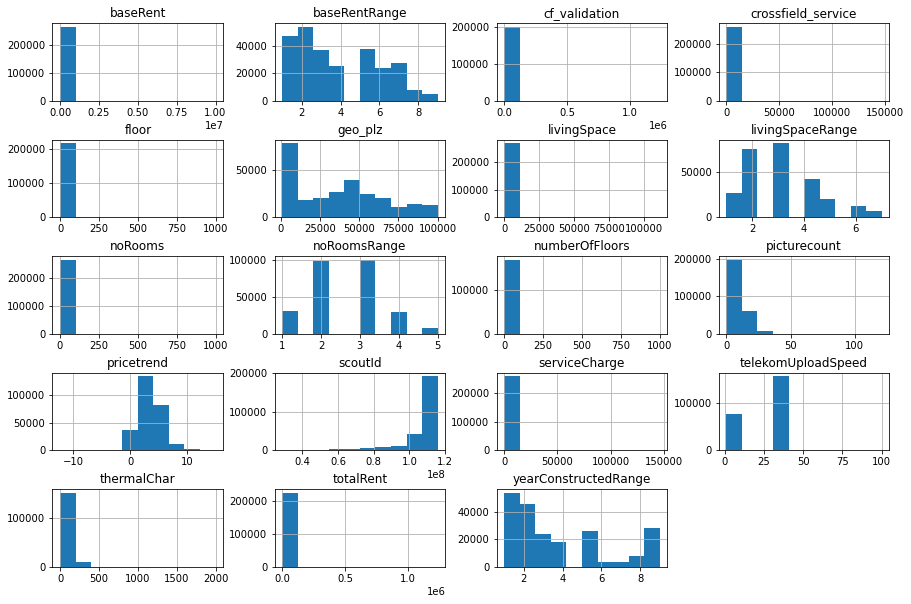

In [65]:
#Plot histograms of numeric features
_ = rentals.select_dtypes(numeric).hist(figsize = (15, 10))
plt.subplots_adjust(hspace= 0.5);

- The distributions of baseRent, floor, livingSpace, noRooms, numberOfFloors, serviceCharge, thermalChar and totalRent are highly skewed to the right.

### 5.6.1 scoutId and geo_plz 

- We first note that scoutId and geo_plz should be objects even though they have numerical representation
- scoutId is the identification number for the property
- geo_plz is the zip code for the property

In [66]:
#Convert scoutId and geo_plz to objects
rentals.scoutId = rentals.scoutId.astype('object')
rentals.geo_plz = rentals.geo_plz.astype('object')
rentals.dtypes['scoutId'], rentals.dtypes['geo_plz']

(dtype('O'), dtype('O'))

In [67]:
#Change geo_plz to zip_code
rentals = rentals.rename(columns = {'geo_plz': 'zip_code'})

### 5.6.2 Reviewing Range Information <br>(yearConstructedRange, baseRentRange, noRoomsRange, livingSpaceRange)</br>

- yearConstructedRange indicates binned construction years from 1 to 9. Determined that 21% of its values are missing, corresponding to the number of missing values for 'yearConstructed'. These are correlated features. Will drop this feature because it likely includes outliers.

- baseRentRange indicates binned base rent. Correlates directly with baseRent. Will drop this feature because it likely includes outliers.

- noRoomsRange indicates binned number of rooms 1 to 5. Redundant feature. Will drop this feature because it likely includes outliers.

- livingSpaceRange is the size of apartment sorted into 7 categories. Redundant feature. Will drop this feature because it likely includes outliers.

In [68]:
#Drop redundant features that may inlcude outliers
rentals.drop(columns = ['yearConstructedRange', 'baseRentRange', 'noRoomsRange', 'livingSpaceRange'], inplace = True)
rentals.select_dtypes(numeric).columns

Index(['serviceCharge', 'picturecount', 'pricetrend', 'telekomUploadSpeed',
       'totalRent', 'baseRent', 'livingSpace', 'noRooms', 'thermalChar',
       'floor', 'numberOfFloors', 'crossfield_service', 'cf_validation'],
      dtype='object')

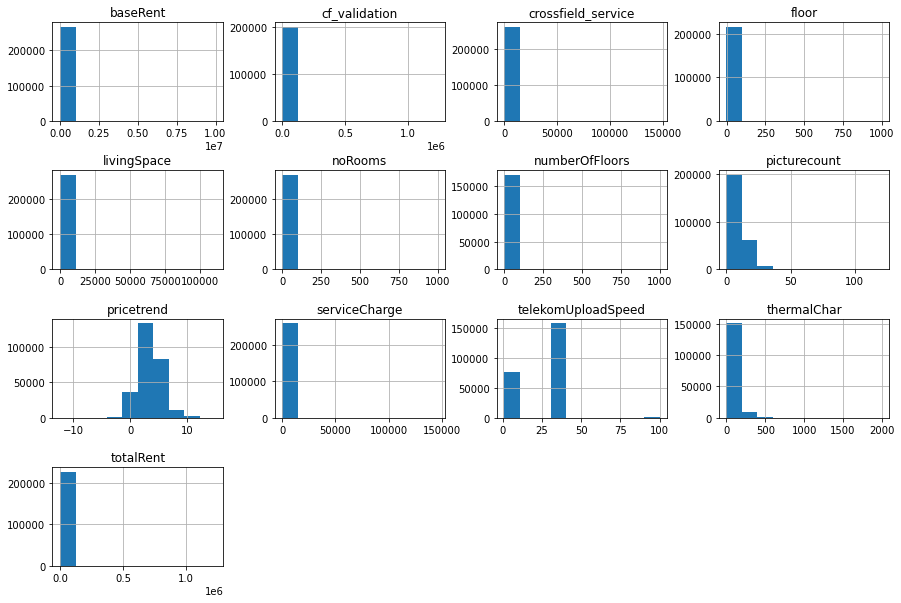

In [69]:
_ = rentals.select_dtypes(numeric).hist(figsize = (15, 10))
plt.subplots_adjust(hspace= 0.5);

### 5.6.3 Reviewing price-related information <br>(baseRent, totalRent, serviceCharge)</br>

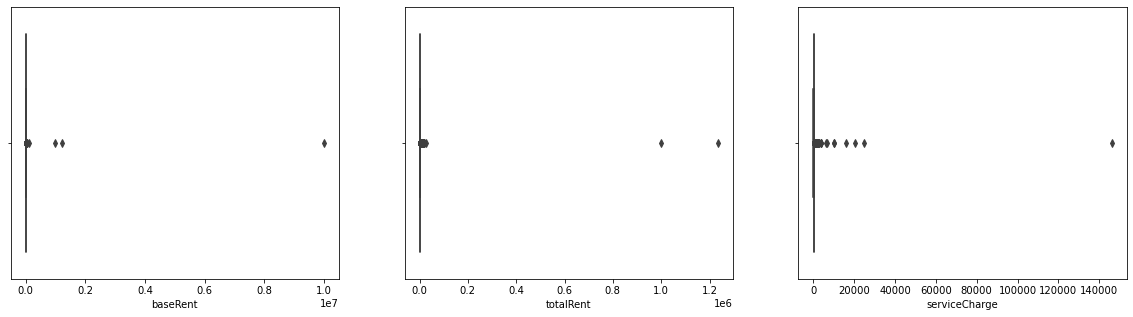

In [70]:
prices = ['baseRent', 'totalRent', 'serviceCharge']

fig, axes = plt.subplots(1, 3, figsize = [20,5])
for idx, price in enumerate(prices):
    _= sns.boxplot(x = price, data = rentals, ax= axes[idx])

In [71]:
#Review summary statistics for baseRent, totalRent and serviceCharge
rentals.baseRent.describe()

count    266577.00
mean        694.99
std       19617.73
min           0.00
25%         338.50
50%         490.00
75%         800.00
max     9999999.00
Name: baseRent, dtype: float64

In [72]:
bRent_q1, bRent_q99 = rentals.baseRent.quantile(0.001), rentals.baseRent.quantile(0.999)
bRent_q1, bRent_q99

(112.38, 4900.0)

In [73]:
rentals.totalRent.describe()

count    226425.00
mean        824.73
std        3384.11
min           0.00
25%         470.00
50%         650.00
75%         985.00
max     1234567.00
Name: totalRent, dtype: float64

In [74]:
tRent_q1, tRent_q99 = rentals.totalRent.quantile(0.01), rentals.totalRent.quantile(0.99)
tRent_q1, tRent_q99

(245.0, 2850.0)

In [75]:
rentals.serviceCharge.describe()

count   259723.00
mean       151.30
std        309.51
min          0.00
25%         95.00
50%        135.00
75%        190.00
max     146118.00
Name: serviceCharge, dtype: float64

- baseRent indicates the rent without electricity or heating. Has a min value of 0 and max value of 9M euros, likely outliers.

- totalRent includes baseRent, serviceCharge and heatingCosts. Determined ~ 15% of its values to be missing. Has min value of 0 euros and max value of 15,751,540 euros. Min and max values are extreme for rents.


- serviceCharge indicates ancillary costs such as electricity or internet. Previously determined that 2.6% of its values are missing. Has a min value of 0 euros and max value of 146,118.0 euros. These may be wrong data.

- We will capture values within three standard deviations from the mean and deem other values to be outliers

In [76]:
#rentals.drop(columns = 'totalRent', inplace = True)

In [77]:
#Creating new variables associated for rent per square meters
rentals['baseRent_per_sqm'] = rentals.baseRent / rentals.livingSpace
rentals['totalRent_per_sqm'] = rentals.totalRent / rentals.livingSpace

In [78]:
#Viewing stats for baseRent_per_sqm
rentals.baseRent_per_sqm.describe()

count   266566.00
mean          inf
std           nan
min          0.00
25%          5.62
50%          7.38
75%         10.18
max           inf
Name: baseRent_per_sqm, dtype: float64

In [79]:
#Viewing stats for baseRent_per_sqm
rentals.totalRent_per_sqm.describe()

count   226420.00
mean          inf
std           nan
min          0.00
25%          7.90
50%          9.76
75%         12.83
max           inf
Name: totalRent_per_sqm, dtype: float64

In [80]:
#Replacing infinities
rentals.replace([np.inf, -np.inf], np.nan, inplace=True)

In [81]:
rentals.baseRent_per_sqm.describe()

count    266503.00
mean         46.74
std       19371.84
min           0.00
25%           5.62
50%           7.38
75%          10.18
max     9999999.00
Name: baseRent_per_sqm, dtype: float64

In [82]:
bRent_sqm_q1, bRent_sqm_q99 = rentals.baseRent_per_sqm.quantile(0.0001), rentals.baseRent_per_sqm.quantile(0.9999)
bRent_sqm_q1, bRent_sqm_q99

(0.0, 97.7378470587599)

In [83]:
rentals.totalRent_per_sqm.describe()

count   226368.00
mean        11.75
std        213.02
min          0.00
25%          7.90
50%          9.76
75%         12.83
max     100000.00
Name: totalRent_per_sqm, dtype: float64

In [84]:
tRent_sqm_q1, tRent_sqm_q99 = rentals.totalRent_per_sqm.quantile(0.001), rentals.totalRent_per_sqm.quantile(0.999)
tRent_sqm_q1, tRent_sqm_q99

(0.0, 53.48404761905494)

In [85]:
cols = ['livingSpace','baseRent','totalRent','cf_validation','baseRent_per_sqm', 'serviceCharge', 'condition',\
        'interiorQual']

In [86]:
lower_baseRent = (rentals.baseRent < bRent_q1) & (rentals.baseRent_per_sqm < bRent_sqm_q1) & \
                (rentals.interiorQual != 'luxury') & (rentals.interiorQual != 'sophisticated')
upper_baseRent = (rentals.baseRent > bRent_q99 ) & (rentals.baseRent_per_sqm > bRent_sqm_q99) & \
                (rentals.interiorQual != 'luxury') & (rentals.interiorQual != 'sophisticated')

In [87]:
rentals.loc[upper_baseRent, cols].sort_values(by = 'baseRent', ascending = False)

,livingSpace,baseRent,totalRent,cf_validation,baseRent_per_sqm,serviceCharge,condition,interiorQual
264934,1.00,9999999.00,nan,nan,9999999.00,nan,NaN,NaN
8406,76.00,1234567.00,1234567.00,1234567.00,16244.30,nan,NaN,NaN
260259,10.00,1000000.00,1000000.00,1000000.00,100000.00,nan,NaN,NaN
176647,47.67,30990.00,449.90,nan,650.09,78.00,NaN,NaN
213625,110.00,20100.00,2390.00,nan,182.73,140.00,well_kept,normal
263502,97.60,9999.00,nan,nan,102.45,9999.00,fully_renovated,NaN
145100,12.00,5000.00,nan,nan,416.67,nan,NaN,NaN
267366,20.00,5000.00,1000.00,nan,250.00,nan,NaN,NaN


In [88]:
rentals.loc[rentals.baseRent > rentals.totalRent, cols].head()

,livingSpace,baseRent,totalRent,cf_validation,baseRent_per_sqm,serviceCharge,condition,interiorQual
1119,49.80,210.00,0.00,nan,4.22,105.00,NaN,NaN
1311,120.00,950.00,200.00,nan,7.92,1150.00,well_kept,normal
1317,33.00,1100.00,1040.00,nan,33.33,60.00,modernized,NaN
1390,128.00,530.00,450.00,nan,4.14,80.00,NaN,NaN
1701,66.00,1832.00,1509.00,nan,27.76,0.00,mint_condition,NaN


In [89]:
rentals['wrong_addition'] = rentals.baseRent + rentals.totalRent

In [90]:
rentals.loc[(rentals.wrong_addition == rentals.serviceCharge), cols]

,livingSpace,baseRent,totalRent,cf_validation,baseRent_per_sqm,serviceCharge,condition,interiorQual
1311,120.00,950.00,200.00,nan,7.92,1150.00,well_kept,normal
5885,75.00,600.00,130.00,nan,8.00,730.00,well_kept,NaN
21992,71.26,0.00,180.00,180.00,0.00,180.00,first_time_use,sophisticated
24858,88.00,390.00,200.00,nan,4.43,590.00,NaN,NaN
33492,94.00,1120.00,250.00,nan,11.91,1370.00,mint_condition,luxury
35630,0.00,0.00,0.00,0.00,nan,0.00,refurbished,luxury
44138,74.68,0.00,180.00,180.00,0.00,180.00,first_time_use,sophisticated
46076,52.00,500.00,115.00,nan,9.62,615.00,NaN,NaN
46213,39.55,826.00,130.00,nan,20.88,956.00,NaN,NaN
47325,32.00,290.00,100.00,nan,9.06,390.00,NaN,NaN


In [91]:
rentals= rentals[~(rentals.wrong_addition == rentals.serviceCharge)]

In [92]:
bad_units = (rentals.baseRent_per_sqm > 1000) | (rentals.totalRent_per_sqm > 1000)

In [93]:
idx = rentals.loc[bad_units, cols].index
rentals.loc[bad_units, cols]

,livingSpace,baseRent,totalRent,cf_validation,baseRent_per_sqm,serviceCharge,condition,interiorQual
7775,1.00,1130.00,1280.00,1280.00,1130.00,150.00,NaN,sophisticated
8406,76.00,1234567.00,1234567.00,1234567.00,16244.30,nan,NaN,NaN
260259,10.00,1000000.00,1000000.00,1000000.00,100000.00,nan,NaN,NaN
264934,1.00,9999999.00,nan,nan,9999999.00,nan,NaN,NaN


In [94]:
idx

Int64Index([7775, 8406, 260259, 264934], dtype='int64')

In [95]:
remove_idx = [7775,8406,260259,264934]

In [96]:
rentals = rentals[~rentals.index.isin(remove_idx)]

In [97]:
bad_units3 = (rentals.baseRent == 0) & rentals.totalRent.isnull()
rentals.loc[bad_units3, cols].sort_values(by = 'baseRent_per_sqm').head()

,livingSpace,baseRent,totalRent,cf_validation,baseRent_per_sqm,serviceCharge,condition,interiorQual
201,45.34,0.00,nan,nan,0.00,90.00,fully_renovated,normal
253681,120.00,0.00,nan,nan,0.00,nan,well_kept,NaN
225352,90.00,0.00,nan,nan,0.00,200.00,NaN,NaN
207680,115.00,0.00,nan,nan,0.00,260.00,NaN,NaN
204092,18.00,0.00,nan,nan,0.00,nan,refurbished,NaN


In [98]:
rentals = rentals[~bad_units3]

In [99]:
rentals.shape

(266522, 36)

In [100]:
bad_units4 = (rentals.baseRent == 0) & (rentals.totalRent == 0)
rentals.loc[bad_units4, cols].sort_values(by = 'baseRent_per_sqm').head(50)

,livingSpace,baseRent,totalRent,cf_validation,baseRent_per_sqm,serviceCharge,condition,interiorQual
176365,80.55,0.00,0.00,0.00,0.00,nan,mint_condition,NaN
69577,0.00,0.00,0.00,0.00,nan,1.50,first_time_use_after_refurbishment,sophisticated
93073,0.00,0.00,0.00,0.00,nan,nan,first_time_use,normal


In [101]:
rentals = rentals[~bad_units4]
rentals.shape

(266519, 36)

In [102]:
bad_units5 = ((rentals.baseRent == 0) & (rentals.serviceCharge.notnull())) & (rentals.serviceCharge != 0)
rentals.loc[bad_units5, cols].sort_values(by = 'baseRent_per_sqm')

,livingSpace,baseRent,totalRent,cf_validation,baseRent_per_sqm,serviceCharge,condition,interiorQual
2045,77.00,0.00,731.50,nan,0.00,154.00,well_kept,NaN
22673,60.00,0.00,410.00,nan,0.00,100.00,well_kept,NaN
55040,47.00,0.00,400.00,nan,0.00,95.00,well_kept,normal
68985,36.00,0.00,410.00,nan,0.00,100.00,NaN,NaN
92860,67.14,0.00,230.00,230.00,0.00,135.00,NaN,NaN
102537,115.00,0.00,1050.00,nan,0.00,350.00,NaN,NaN
103052,65.00,0.00,600.00,nan,0.00,200.00,NaN,NaN
127349,59.00,0.00,420.00,nan,0.00,120.00,fully_renovated,NaN
130651,73.00,0.00,700.80,nan,0.00,146.00,well_kept,NaN
143557,32.49,0.00,484.00,nan,0.00,99.00,NaN,NaN


In [103]:
rentals.loc[bad_units5, ['baseRent']] = rentals.loc[bad_units5, 'totalRent'] - rentals.loc[bad_units5, 'serviceCharge']

In [104]:
rentals.loc[bad_units5, cols].sort_values(by = 'baseRent_per_sqm')

,livingSpace,baseRent,totalRent,cf_validation,baseRent_per_sqm,serviceCharge,condition,interiorQual
2045,77.00,577.50,731.50,nan,0.00,154.00,well_kept,NaN
22673,60.00,310.00,410.00,nan,0.00,100.00,well_kept,NaN
55040,47.00,305.00,400.00,nan,0.00,95.00,well_kept,normal
68985,36.00,310.00,410.00,nan,0.00,100.00,NaN,NaN
92860,67.14,95.00,230.00,230.00,0.00,135.00,NaN,NaN
102537,115.00,700.00,1050.00,nan,0.00,350.00,NaN,NaN
103052,65.00,400.00,600.00,nan,0.00,200.00,NaN,NaN
127349,59.00,300.00,420.00,nan,0.00,120.00,fully_renovated,NaN
130651,73.00,554.80,700.80,nan,0.00,146.00,well_kept,NaN
143557,32.49,385.00,484.00,nan,0.00,99.00,NaN,NaN


In [105]:
bad_units6 = (rentals.livingSpace == 0)
rentals.loc[bad_units6, cols].sort_values(by = 'baseRent_per_sqm')

,livingSpace,baseRent,totalRent,cf_validation,baseRent_per_sqm,serviceCharge,condition,interiorQual
3444,0.00,620.00,890.00,890.00,nan,130.00,NaN,NaN
6601,0.00,35.00,35.00,35.00,nan,0.00,well_kept,normal
11127,0.00,775.00,865.00,865.00,nan,90.00,well_kept,normal
15014,0.00,110.00,110.00,110.00,nan,0.00,NaN,NaN
17278,0.00,160.00,nan,nan,nan,69.00,NaN,NaN
...,...,...,...,...,...,...,...,...
247111,0.00,450.00,490.00,490.00,nan,40.00,mint_condition,normal
248599,0.00,325.00,465.00,465.00,nan,140.00,well_kept,normal
254055,0.00,0.00,470.00,nan,nan,nan,first_time_use_after_refurbishment,NaN
266160,0.00,450.00,480.00,480.00,nan,30.00,NaN,NaN


In [106]:
rentals = rentals.loc[~bad_units6]
rentals.shape

(266453, 36)

In [107]:
bad_units6 = (rentals.totalRent ==  0) 
rentals.loc[bad_units6, cols].sort_values(by = 'baseRent_per_sqm')

,livingSpace,baseRent,totalRent,cf_validation,baseRent_per_sqm,serviceCharge,condition,interiorQual
97475,600.00,340.00,0.00,nan,0.57,nan,fully_renovated,NaN
35197,77.00,231.00,0.00,nan,3.00,73.00,NaN,NaN
98391,73.00,250.00,0.00,nan,3.42,180.00,NaN,NaN
48701,82.00,285.00,0.00,nan,3.48,180.00,NaN,NaN
5739,63.11,220.50,0.00,nan,3.49,75.00,NaN,NaN
...,...,...,...,...,...,...,...,...
132091,80.00,1099.00,0.00,nan,13.74,0.00,mint_condition,luxury
123373,60.00,980.00,0.00,nan,16.33,0.00,first_time_use_after_refurbishment,sophisticated
146770,73.33,1261.00,0.00,nan,17.20,238.00,first_time_use,NaN
196593,35.00,619.00,0.00,nan,17.69,0.00,well_kept,NaN


In [108]:
bad_units7 = (rentals.baseRent == 0) 
rentals.loc[bad_units7, cols].sort_values(by = 'baseRent_per_sqm')

,livingSpace,baseRent,totalRent,cf_validation,baseRent_per_sqm,serviceCharge,condition,interiorQual
1377,30.00,0.00,700.00,nan,0.00,nan,fully_renovated,normal
242193,60.00,0.00,1300.00,nan,0.00,0.00,mint_condition,sophisticated
237975,57.00,0.00,650.00,nan,0.00,nan,modernized,NaN
234202,65.00,0.00,600.00,nan,0.00,nan,NaN,NaN
225417,100.00,0.00,800.00,nan,0.00,nan,modernized,NaN
225235,45.00,0.00,695.00,nan,0.00,0.00,well_kept,normal
224299,28.00,0.00,325.00,nan,0.00,nan,well_kept,NaN
223839,49.00,0.00,800.00,nan,0.00,nan,fully_renovated,NaN
206003,43.00,0.00,480.00,nan,0.00,nan,well_kept,NaN
197600,74.00,0.00,650.00,nan,0.00,nan,well_kept,NaN


In [109]:
rentals.loc[bad_units7, ['baseRent']] = rentals.loc[bad_units7, 'totalRent']

In [110]:
rentals.loc[bad_units7, cols].sort_values(by = 'baseRent_per_sqm')

,livingSpace,baseRent,totalRent,cf_validation,baseRent_per_sqm,serviceCharge,condition,interiorQual
1377,30.00,700.00,700.00,nan,0.00,nan,fully_renovated,normal
242193,60.00,1300.00,1300.00,nan,0.00,0.00,mint_condition,sophisticated
237975,57.00,650.00,650.00,nan,0.00,nan,modernized,NaN
234202,65.00,600.00,600.00,nan,0.00,nan,NaN,NaN
225417,100.00,800.00,800.00,nan,0.00,nan,modernized,NaN
225235,45.00,695.00,695.00,nan,0.00,0.00,well_kept,normal
224299,28.00,325.00,325.00,nan,0.00,nan,well_kept,NaN
223839,49.00,800.00,800.00,nan,0.00,nan,fully_renovated,NaN
206003,43.00,480.00,480.00,nan,0.00,nan,well_kept,NaN
197600,74.00,650.00,650.00,nan,0.00,nan,well_kept,NaN


In [111]:
bad_units8 = (rentals.baseRent_per_sqm < 1) & rentals.totalRent.isnull()
rentals.loc[bad_units8, cols].sort_values(by = 'baseRent_per_sqm')

,livingSpace,baseRent,totalRent,cf_validation,baseRent_per_sqm,serviceCharge,condition,interiorQual
262089,187.70,1.00,nan,nan,0.01,nan,NaN,NaN
236543,55.00,1.00,nan,nan,0.02,nan,negotiable,NaN
220278,40.00,1.00,nan,nan,0.03,nan,NaN,NaN
229248,4947.00,200.00,nan,nan,0.04,140.00,well_kept,NaN
30974,300.00,15.00,nan,nan,0.05,nan,first_time_use_after_refurbishment,NaN
202205,7008.00,519.00,nan,nan,0.07,107.00,well_kept,normal
215900,2782.00,245.00,nan,nan,0.09,60.00,fully_renovated,NaN
201135,72.00,8.00,nan,nan,0.11,nan,first_time_use,NaN
222457,2420.00,283.14,nan,nan,0.12,99.35,well_kept,normal
109023,116.00,14.00,nan,nan,0.12,nan,first_time_use,sophisticated


In [112]:
rentals = rentals[~bad_units8]
rentals.shape

(266428, 36)

In [113]:
bad_units9 = (rentals.livingSpace > 900)
rentals.loc[bad_units9, cols].sort_values(by = 'baseRent_per_sqm')

,livingSpace,baseRent,totalRent,cf_validation,baseRent_per_sqm,serviceCharge,condition,interiorQual
175397,111111.00,679.00,369.00,nan,0.01,nan,NaN,NaN
151184,66100.00,1200.00,1400.00,1400.00,0.02,115.00,well_kept,sophisticated
172399,4340.00,200.00,260.00,260.00,0.05,60.00,well_kept,NaN
51540,8684.00,504.00,650.00,650.00,0.06,146.00,modernized,NaN
223187,10259.00,1385.00,1641.50,1641.50,0.14,128.25,mint_condition,sophisticated
227775,1000.00,539.00,541.50,541.50,0.54,2.50,first_time_use,sophisticated
243713,14000.00,120000.00,nan,nan,8.57,25000.00,well_kept,sophisticated


In [114]:
rentals = rentals[~bad_units9]
rentals.shape

(266421, 36)

In [115]:
bad_units10 = (rentals.baseRent_per_sqm < 1) & (rentals.totalRent > 2 * rentals.baseRent)
rentals.loc[bad_units10, cols].sort_values(by = 'baseRent_per_sqm', ascending = False)

,livingSpace,baseRent,totalRent,cf_validation,baseRent_per_sqm,serviceCharge,condition,interiorQual
31096,48.93,11.20,658.02,nan,0.23,110.00,first_time_use,sophisticated
136387,70.00,11.00,720.00,nan,0.16,200.00,first_time_use,sophisticated
204024,78.86,9.50,960.00,nan,0.12,105.00,first_time_use,sophisticated
170159,100.00,12.00,162.00,162.00,0.12,150.00,first_time_use,sophisticated
168365,48.39,4.96,326.00,nan,0.10,43.00,mint_condition,NaN
203671,57.00,5.25,419.00,nan,0.09,60.00,refurbished,NaN
194124,58.06,3.01,291.00,nan,0.05,58.00,refurbished,NaN
121531,130.00,5.90,767.00,nan,0.05,190.00,NaN,sophisticated
110217,133.28,6.00,800.00,nan,0.05,150.00,modernized,normal
113112,80.00,3.00,400.00,nan,0.04,80.00,refurbished,NaN


In [116]:
rentals.loc[bad_units10, ['baseRent']] = rentals.loc[bad_units10, 'totalRent']
rentals.loc[bad_units10, ['baseRent_per_sqm']] = rentals.loc[bad_units10, 'baseRent'] / rentals.loc[bad_units10, 'livingSpace']
rentals.loc[bad_units10, cols].sort_values(by = 'baseRent_per_sqm', ascending = False)

,livingSpace,baseRent,totalRent,cf_validation,baseRent_per_sqm,serviceCharge,condition,interiorQual
31096,48.93,658.02,658.02,nan,13.45,110.00,first_time_use,sophisticated
204024,78.86,960.00,960.00,nan,12.17,105.00,first_time_use,sophisticated
136387,70.00,720.00,720.00,nan,10.29,200.00,first_time_use,sophisticated
203671,57.00,419.00,419.00,nan,7.35,60.00,refurbished,NaN
168365,48.39,326.00,326.00,nan,6.74,43.00,mint_condition,NaN
110217,133.28,800.00,800.00,nan,6.00,150.00,modernized,normal
121531,130.00,767.00,767.00,nan,5.90,190.00,NaN,sophisticated
151820,143.53,840.00,840.00,nan,5.85,140.00,refurbished,NaN
192355,135.00,784.00,784.00,nan,5.81,134.00,first_time_use_after_refurbishment,NaN
194124,58.06,291.00,291.00,nan,5.01,58.00,refurbished,NaN


In [117]:
bad_units11 = (rentals.baseRent_per_sqm < 1) 
rentals.loc[bad_units11, cols].sort_values(by = 'baseRent_per_sqm', ascending = False)

,livingSpace,baseRent,totalRent,cf_validation,baseRent_per_sqm,serviceCharge,condition,interiorQual
12420,649.00,520.00,720.00,720.00,0.80,200.00,first_time_use_after_refurbishment,NaN
97475,600.00,340.00,0.00,nan,0.57,nan,fully_renovated,NaN
114050,115.00,25.00,25.00,25.00,0.22,nan,NaN,NaN
34045,42.57,6.00,7.55,7.55,0.14,1.55,fully_renovated,sophisticated
22609,80.00,10.00,10.00,10.00,0.12,nan,NaN,NaN
...,...,...,...,...,...,...,...,...
104133,55.00,500.00,500.00,nan,0.00,nan,NaN,sophisticated
118633,62.00,600.00,600.00,nan,0.00,nan,NaN,NaN
127349,59.00,300.00,420.00,nan,0.00,120.00,fully_renovated,NaN
2045,77.00,577.50,731.50,nan,0.00,154.00,well_kept,NaN


In [118]:
rentals = rentals[~bad_units11]
rentals.shape

(266358, 36)

In [119]:
rentals['sqm_per_room'] = rentals.livingSpace / rentals.noRooms

In [120]:
cols2 = ['baseRent', 'serviceCharge','totalRent','noRooms','livingSpace', 'condition',\
        'interiorQual', 'sqm_per_room', 'baseRent_per_sqm']

In [121]:
bad_units12 = (rentals.sqm_per_room < 8) 
rentals.loc[bad_units12, cols2].sort_values(by = 'sqm_per_room', ascending = False)

,baseRent,serviceCharge,totalRent,noRooms,livingSpace,condition,interiorQual,sqm_per_room,baseRent_per_sqm
63561,50.00,nan,50.00,1.00,7.70,NaN,NaN,7.70,6.49
145157,400.00,75.00,nan,4.00,30.00,well_kept,NaN,7.50,13.33
77676,150.00,130.00,nan,1.00,7.00,NaN,normal,7.00,21.43
67256,277.00,87.00,364.00,5.00,34.60,refurbished,NaN,6.92,8.01
250562,230.00,70.00,300.00,3.00,20.00,well_kept,NaN,6.67,11.50
...,...,...,...,...,...,...,...,...,...
18961,395.00,0.00,395.00,140.00,14.00,well_kept,normal,0.10,28.21
103615,282.00,140.00,nan,999.99,61.17,first_time_use,NaN,0.06,4.61
156291,247.00,58.00,nan,45.00,2.00,refurbished,NaN,0.04,123.50
163563,400.00,150.00,550.00,30.00,1.00,first_time_use,sophisticated,0.03,400.00


In [122]:
rentals = rentals[~bad_units12]
rentals.shape

(266251, 37)

In [123]:
rentals['baseRent_per_room'] = rentals.baseRent / rentals.noRooms
rentals[['baseRent_per_room']]

,baseRent_per_room
0,148.75
1,266.67
2,321.67
3,114.33
4,255.00
...,...
268845,273.33
268846,265.71
268847,162.50
268848,420.00


In [124]:
cols3 = ['baseRent', 'serviceCharge','totalRent','noRooms','livingSpace', 'condition',\
        'interiorQual', 'baseRent_per_room', 'baseRent_per_sqm']
bad_units13 = rentals.baseRent_per_room < 30
rentals.loc[bad_units13, cols3].sort_values(by = 'baseRent_per_room', ascending = False)

,baseRent,serviceCharge,totalRent,noRooms,livingSpace,condition,interiorQual,baseRent_per_room,baseRent_per_sqm
211685,450.00,80.00,530.00,16.00,446.00,first_time_use_after_refurbishment,sophisticated,28.12,1.01
149728,42.00,115.00,535.00,1.50,42.00,modernized,NaN,28.00,1.00
206309,28.00,nan,28.00,1.00,12.00,well_kept,normal,28.00,2.33
11922,25.00,nan,25.00,1.00,12.50,mint_condition,NaN,25.00,2.00
130612,25.00,nan,nan,1.00,12.00,mint_condition,normal,25.00,2.08
266668,22.00,0.00,nan,1.00,15.00,modernized,normal,22.00,1.47
82993,15.00,0.00,nan,1.00,15.00,modernized,normal,15.00,1.00
112028,100.00,99.00,199.00,7.00,100.00,NaN,normal,14.29,1.00


In [125]:
rentals = rentals[~bad_units13]

- Distributions are still right skewed, but there is a bit more spread than the original histograms. 

### Review Other Numeric Features
#### 5.6.4 picturecount 

- picturecount indicates how many pictures were loaded to the listing. Min of 0 and max of 121 makes sense. 


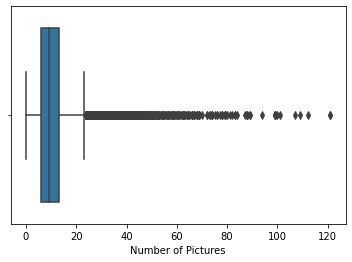

In [126]:
_= sns.boxplot(x = 'picturecount', data = rentals)
_= plt.xlabel('Number of Pictures')

#### 5.6.5 pricetrend 

- pricetrend is a parameter calculated by immoscout. Calculation or metric was not provided, however, it likely indicates the percentage change in price for that apartment or similar apartments in the area. Observed that ~ 0.7% of its values are missing. Has a min value of -12 and max value of 14.9. Range seems reasonable at first glance.


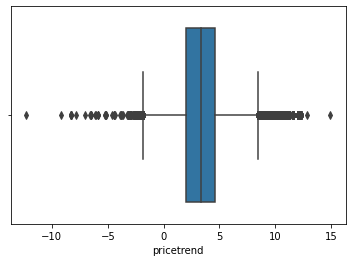

In [127]:
_= sns.boxplot(x = 'pricetrend', data = rentals)
_= plt.xlabel('pricetrend')

#### 5.6.6 telekomUploadSpeed 

- telekomUploadSpeed indicates internet upload speed. Determined that 12.4% of its values are missing. Unit not provided, but is typically measured in Mbps. Has seven values, with min speed of 1 and max speed of 100. Range seems reasonable at first glance. 


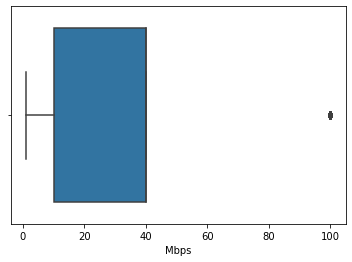

In [128]:
_= sns.boxplot(x = 'telekomUploadSpeed', data = rentals)
_= plt.xlabel('Mbps')

In [129]:
rentals.telekomUploadSpeed.value_counts()

40.00     156759
2.40       42450
10.00      32591
5.00        1019
1.00         206
100.00       141
4.00          63
Name: telekomUploadSpeed, dtype: int64

#### 5.6.7 livingSpace 

- livingSpace indicates living space in sqm. Min value of 0 and max value of 110,000 sqm, likely outliers.


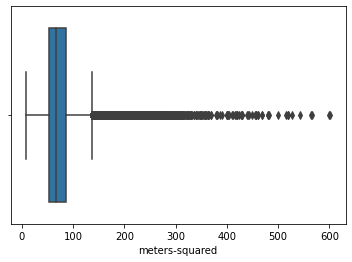

In [130]:
_= sns.boxplot(x = 'livingSpace', data = rentals)
_= plt.xlabel('meters-squared')

In [131]:
#Determine ideal upper and lower bounds for livingSpace if livingSpace was normally distributed
rentals.livingSpace.describe()

count   266243.00
mean        73.54
std         32.04
min          8.00
25%         54.00
50%         67.40
75%         87.00
max        601.85
Name: livingSpace, dtype: float64

#### 5.6.8 noRooms 

- noRooms indicates number of rooms in apartment. Min value of 1. Max value of 999, likely an outlier. 

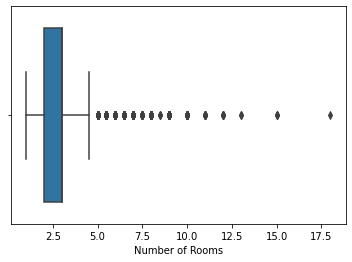

In [132]:
_= sns.boxplot(x = 'noRooms', data = rentals)
_= plt.xlabel('Number of Rooms')

In [133]:
rentals.noRooms.describe()

count   266243.00
mean         2.63
std          0.98
min          1.00
25%          2.00
50%          3.00
75%          3.00
max         18.00
Name: noRooms, dtype: float64

- We notice units having more than 100 rooms.

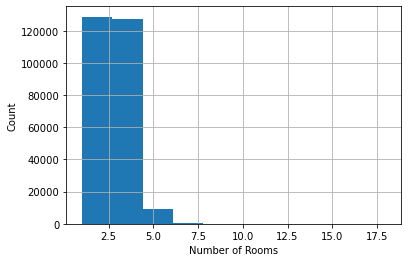

In [134]:
#Review distribution
_= rentals.noRooms.hist()
_= plt.xlabel('Number of Rooms')
_= plt.ylabel('Count')

#### 5.6.9 thermalChar 

- thermalChar indicates energy demand of apartment. Data owner noted that it is used to determine energyEfficiencyClass. Has unit - kWh/(m^2a) [Kilowatt per square meter per annum] Determined that ~ 40% of its values are missing. Has a min value of 0.1 and max value of 1996. Values seem extreme. 


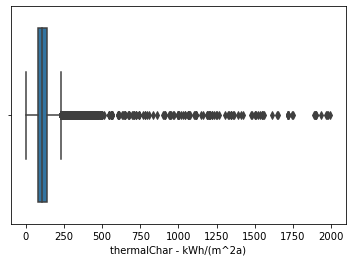

In [135]:
_= sns.boxplot(x = 'thermalChar', data = rentals)
_= plt.xlabel('thermalChar - kWh/(m^2a)')

- For typical apartment building, thermalChar is between 20 and 120 KWh / (m^2a)

In [136]:
cols4 = ['baseRent','noRooms','livingSpace', 'condition', \
        'interiorQual', 'firingTypes', 'yearConstructed', 'thermalChar']
rentals.loc[rentals.thermalChar > 1200, cols4].sort_values(by = 'thermalChar', ascending = False)

,baseRent,noRooms,livingSpace,condition,interiorQual,firingTypes,yearConstructed,thermalChar
71601,650.00,4.00,105.63,NaN,NaN,NaN,NaT,1996.00
123270,374.00,2.00,67.00,NaN,NaN,district_heating,1983-01-01,1983.00
57965,308.00,3.00,61.03,well_kept,normal,district_heating,1974-01-01,1974.00
217982,800.00,3.00,80.00,well_kept,NaN,gas,1968-01-01,1971.00
246864,1200.00,3.00,110.00,mint_condition,NaN,NaN,2017-01-01,1932.00
122066,265.00,2.00,44.80,NaN,NaN,gas,NaT,1900.00
101444,265.00,2.00,44.80,NaN,NaN,gas,NaT,1900.00
204426,173.00,1.00,35.38,NaN,normal,gas,1897-01-01,1897.00
262421,173.00,1.00,35.38,NaN,normal,gas,1897-01-01,1897.00
46204,550.00,3.00,76.00,mint_condition,sophisticated,NaN,2018-01-01,1890.00


- 123270 and 57965 are dates. We will remove these rows

In [137]:
rentals = rentals.loc[~rentals.index.isin([123270, 57965])]

In [138]:
rentals.loc[rentals.thermalChar < 1, cols4].sort_values(by = 'thermalChar')

,baseRent,noRooms,livingSpace,condition,interiorQual,firingTypes,yearConstructed,thermalChar
21962,624.00,3.00,78.00,well_kept,NaN,oil,1968-01-01,0.10
57693,695.00,2.00,46.23,first_time_use,sophisticated,natural_gas_light,2018-01-01,0.20
53510,1195.00,3.00,105.78,first_time_use,NaN,gas,2019-01-01,0.20
47158,1195.00,3.00,105.78,first_time_use,luxury,gas,2019-01-01,0.20
125961,1195.00,3.00,105.78,first_time_use,luxury,gas,2019-01-01,0.20
127217,1590.00,3.00,92.00,first_time_use_after_refurbishment,sophisticated,coal_coke,2019-01-01,0.25
156348,764.64,2.00,70.80,first_time_use,sophisticated,district_heating,2017-01-01,0.27
228995,360.00,2.50,55.00,modernized,sophisticated,gas,1965-01-01,0.28
31114,1195.00,3.00,61.30,first_time_use,sophisticated,gas,2017-01-01,0.30
30229,1050.00,2.00,50.80,first_time_use,sophisticated,gas,2017-01-01,0.30


- thermalChar has low values for mostly apartments that have had some work done to them (e.g. first_time_use, full_renovated, etc.)

#### 5.6.10 floor and numberOfFloors

- floor indicates floor number of apartment. Determined that 19% of its values are missing. Has 53 unique values, with min of -1 and max of 999. Min of -1 likely indicates a basement apartment, but a max of 999 is an extreme value. Floor number is an identifier for the apartment specific to the building.
- numberOfFloors indicates the number of floors in the building. Has 57 unique values, with min of 0 and max of 999, similar to 'floor'. 999 is an extreme values.

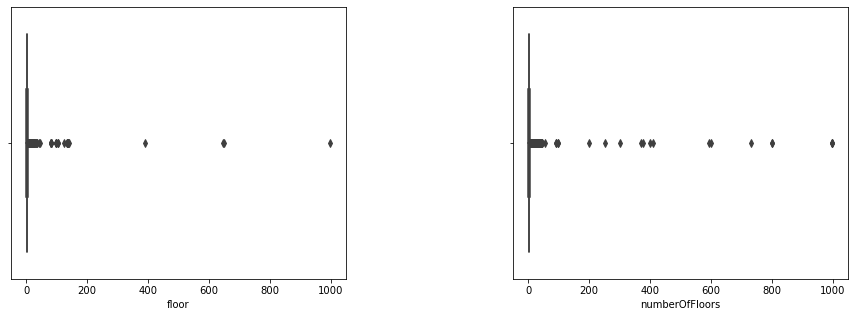

In [139]:
fig, ax = plt.subplots(nrows = 1,ncols = 2, figsize=(15, 5))
_= sns.boxplot(x = 'floor', data = rentals, ax = ax[0])
_= sns.boxplot(x = 'numberOfFloors', data = rentals, ax = ax[1])
plt.subplots_adjust(wspace= 0.5)
plt.show()

- Tallest German building has 56 floors. We will filter with this limit. Also we note that the numberOfFloors provides a relates better to price than the number of the floor. We will drop floor.

In [140]:
#Drop floor
rentals.drop('floor', axis =1, inplace = True)

In [141]:
#Remove outliers in numberOfFloors
cols5 = ['baseRent','noRooms','livingSpace', 'condition', \
        'interiorQual', 'yearConstructed', 'typeOfFlat', 'numberOfFloors', 'totalRent']
rentals.loc[(rentals.numberOfFloors > 56), cols5]

,baseRent,noRooms,livingSpace,condition,interiorQual,yearConstructed,typeOfFlat,numberOfFloors,totalRent
26590,570.00,1.50,40.00,well_kept,NaN,NaT,roof_storey,90.00,nan
35220,245.00,1.50,44.20,well_kept,normal,NaT,other,301.00,2.00
43275,378.00,2.00,61.00,fully_renovated,normal,1935-01-01,apartment,378.00,512.00
48498,600.00,2.00,50.00,mint_condition,sophisticated,1976-01-01,apartment,999.00,720.00
64453,500.00,2.50,92.00,well_kept,normal,1982-01-01,raised_ground_floor,92.00,620.00
72253,680.00,2.00,69.00,mint_condition,sophisticated,1985-01-01,ground_floor,999.00,850.00
82112,280.00,1.00,52.50,well_kept,NaN,1995-01-01,apartment,400.00,4.00
100789,300.00,1.00,27.00,well_kept,normal,1973-01-01,other,999.00,nan
107377,560.00,2.00,75.00,NaN,NaN,NaT,roof_storey,800.00,680.00
123333,399.00,2.00,73.00,well_kept,normal,1954-01-01,apartment,594.00,nan


- We will remove numberOfFloors > 56

In [142]:
rentals = rentals.loc[~(rentals.numberOfFloors > 56)]

In [143]:
rentals.shape

(266222, 37)

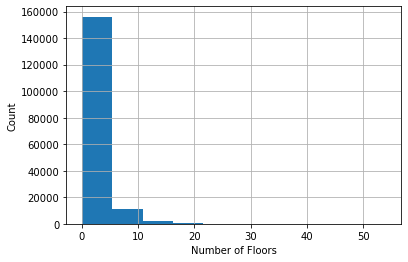

In [144]:
#Review distribution
_= rentals.numberOfFloors.hist()
_= plt.xlabel('Number of Floors')
_= plt.ylabel('Count')

## 5.7 Review of Boolean Features

In [145]:
rentals.select_dtypes('boolean').head()

,newlyConst,balcony,hasKitchen,cellar,lift,garden
0,False,False,False,True,False,True
1,False,True,False,False,False,False
2,True,True,False,True,True,False
3,False,True,False,False,False,False
4,False,True,False,False,False,False


In [146]:
#Review missing values
rentals.select_dtypes('boolean').isna().sum()

newlyConst    0
balcony       0
hasKitchen    0
cellar        0
lift          0
garden        0
dtype: int64

## 5.8 Review Datatime Features 

In [147]:
rentals.select_dtypes('datetime').head()

,yearConstructed,date
0,1965-01-01,2019-05-01
1,1871-01-01,2019-05-01
2,2019-01-01,2019-10-01
3,1964-01-01,2019-05-01
4,1950-01-01,2020-02-01


### 5.8.1 yearConstructed

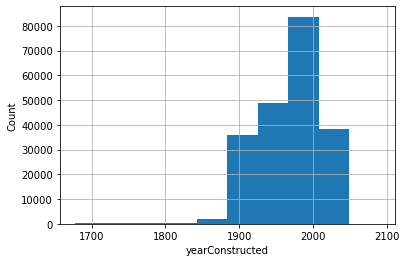

In [148]:
#Plot distribution
_ = rentals.yearConstructed.dt.year.hist()
_= plt.xlabel('yearConstructed')
_= plt.ylabel('Count')

- There are dates past 2020

In [149]:
rentals.loc[rentals.yearConstructed.dt.year >= 2026, ['state','date','baseRent', 'yearConstructed', 'condition', 'interiorQual']]

,state,date,baseRent,yearConstructed,condition,interiorQual
40265,Berlin,2020-02-01,470.00,2029-01-01,first_time_use,sophisticated
54595,Hessen,2019-10-01,2945.00,2026-01-01,mint_condition,NaN
87221,Baden_Württemberg,2019-05-01,1175.00,2090-01-01,mint_condition,NaN
182121,Hessen,2019-10-01,1620.00,2026-01-01,mint_condition,NaN
240346,Hessen,2019-10-01,1435.00,2026-01-01,mint_condition,NaN


- We observe than many of the units are first-time use. We will remove rows for values in 2029 and 2090 because the are too far out.

In [150]:
#Filter-out outliers
rentals = rentals[~rentals.index.isin([40265, 87221])]
rentals[rentals.yearConstructed.dt.year > 2026]

,state,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,firingTypes,hasKitchen,cellar,baseRent,livingSpace,condition,interiorQual,petsAllowed,lift,typeOfFlat,zip_code,noRooms,thermalChar,numberOfFloors,garden,district,town_municipality,date,crossfield_service,cf_validation,baseRent_per_sqm,totalRent_per_sqm,wrong_addition,sqm_per_room,baseRent_per_room


In [151]:
rentals.shape

(266220, 37)

## 5.9 State-wide Features

### 5.9.2 State Profile

In [152]:
#Load German states information
states_url = 'https://en.wikipedia.org/wiki/States_of_Germany'
german_states = pd.read_html(states_url)

In [153]:
states = german_states[5]
states

,Coat of arms,Flag,State,Since,Capital,Legislature,Head of government,Governmentcoalition,Bundesrat votes,Area(km2),Population(Dec. 2019)[7],Pop.per km2,HDI(2018)[8],ISO3166-2code,GDP per capita in Euro (2018)[9]
0,nan,nan,Baden-Württemberg,1952[10],Stuttgart,Landtag of Baden-Württemberg,Winfried Kretschmann (Greens),"Greens, CDU",6,35752,11100394,310,0.95,BW,47290
1,nan,nan,Bavaria(Bayern),1949,Munich(München),Landtag of Bavaria,Markus Söder (CSU),"CSU, FW",6,70552,13124737,185,0.95,BY,48323
2,nan,nan,Berlin,1990[11],–,Abgeordnetenhaus,Michael Müller (SPD),"SPD, The Left, Greens",4,892,3669491,4086,0.95,BE,41967
3,nan,nan,Brandenburg,1990,Potsdam,Landtag of Brandenburg,Dietmar Woidke (SPD),"SPD, CDU, Greens",4,29479,2521893,85,0.91,BB,29541
4,nan,nan,Bremen,1949,Bremen,Bürgerschaft of Bremen,Andreas Bovenschulte (SPD),"SPD, Greens, The Left",3,419,681202,1630,0.95,HB,49215
5,nan,nan,Hamburg,1949,–,Bürgerschaft of Hamburg,Peter Tschentscher (SPD),"SPD, Greens",3,755,1847253,2439,0.97,HH,66879
6,nan,nan,Hesse(Hessen),1949,Wiesbaden,Landtag of Hesse,Volker Bouffier (CDU),"CDU, Greens",5,21115,6288080,297,0.95,HE,46923
7,nan,nan,Lower Saxony(Niedersachsen),1949,Hanover(Hannover),Landtag of Lower Saxony,Stephan Weil (SPD),"SPD, CDU",6,47609,7993448,168,0.92,NI,38423
8,nan,nan,Mecklenburg-Vorpommern,1990,Schwerin,Landtag of Mecklenburg-Vorpommern,Manuela Schwesig (SPD),"SPD, CDU",3,23180,1609675,69,0.91,MV,28940
9,nan,nan,North Rhine-Westphalia(Nordrhein-Westfalen),1949,Düsseldorf,Landtag of North Rhine-Westphalia,Armin Laschet (CDU),"CDU, FDP",6,34085,17932651,526,0.94,NW,39678


In [154]:
state_features = states[['State', 'Area(km2)', 'Population(Dec. 2019)[7]', 'Pop.per km2', 'GDP per capita in Euro (2018)[9]', 'HDI(2018)[8]']]
state_features.head()

,State,Area(km2),Population(Dec. 2019)[7],Pop.per km2,GDP per capita in Euro (2018)[9],HDI(2018)[8]
0,Baden-Württemberg,35752,11100394,310,47290,0.95
1,Bavaria(Bayern),70552,13124737,185,48323,0.95
2,Berlin,892,3669491,4086,41967,0.95
3,Brandenburg,29479,2521893,85,29541,0.91
4,Bremen,419,681202,1630,49215,0.95


In [155]:
state_features.columns = ['State', 'area_km2', 'population_2019', 'population_per_km2', 'gdp_per_capita_2018', 'hdi']
state_features.head()

,State,area_km2,population_2019,population_per_km2,gdp_per_capita_2018,hdi
0,Baden-Württemberg,35752,11100394,310,47290,0.95
1,Bavaria(Bayern),70552,13124737,185,48323,0.95
2,Berlin,892,3669491,4086,41967,0.95
3,Brandenburg,29479,2521893,85,29541,0.91
4,Bremen,419,681202,1630,49215,0.95


In [156]:
rentals.shape

(266220, 37)

## 5.10 Target feature 

- We need to choose between totalRent and baseRent for our modelling. 

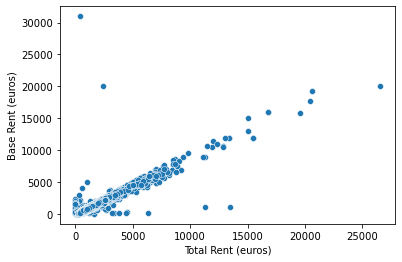

In [157]:
#Review relationship between baseRent and totalRent
_= sns.scatterplot(x = 'totalRent', y = 'baseRent', data = rentals)
_= plt.xlabel('Total Rent (euros)')
_= plt.ylabel('Base Rent (euros)')

In [158]:
#Count missing values of totalRent and baseRent
rentals.totalRent.isnull().sum(), rentals.baseRent.isnull().sum()

(40055, 0)

- We note that thare are over 40,000 missing values for totalRent and 0 missing values for baseRent.
- We note that totalRent is composed of baseRent and other features. 
- We will therefore use baseRent as our target feature and drop totalRent

In [159]:
#Recalculating parameters
rentals.baseRent_per_sqm = rentals.baseRent / rentals.livingSpace

In [160]:
rentals.columns

Index(['state', 'serviceCharge', 'heatingType', 'telekomTvOffer', 'newlyConst',
       'balcony', 'picturecount', 'pricetrend', 'telekomUploadSpeed',
       'totalRent', 'yearConstructed', 'scoutId', 'firingTypes', 'hasKitchen',
       'cellar', 'baseRent', 'livingSpace', 'condition', 'interiorQual',
       'petsAllowed', 'lift', 'typeOfFlat', 'zip_code', 'noRooms',
       'thermalChar', 'numberOfFloors', 'garden', 'district',
       'town_municipality', 'date', 'crossfield_service', 'cf_validation',
       'baseRent_per_sqm', 'totalRent_per_sqm', 'wrong_addition',
       'sqm_per_room', 'baseRent_per_room'],
      dtype='object')

In [161]:
#Dropping unwanted columns
rentals.drop(columns = ['totalRent', 'crossfield_service', 'cf_validation', 'totalRent_per_sqm', \
                        'wrong_addition', 'sqm_per_room', 'baseRent_per_room'], inplace = True)

In [162]:
rentals.shape

(266220, 30)

# 6. Summary

- We started with a dataframe of 268,850 rows and 49 columns
- We concluded with a dataframe of 266,568 rows and 29 columns
- We removed columns that had over 40% of their values missing
- We removed duplicated rows
- We removed redundant columns that had high cardinality and offered no clear benefits
- We removed columns that were aggregrate values of other columns. These were columns with binned data derived from other columns
- We removed rows with missing rent information
- We removed rows with outlier values for particular numerical features
- We imported data associated with state-wise features
- Finally, we chose the baseRent feature as our target feature.

# 7. Saving New Dataframes

In [163]:
datapath = '..\data\processed'
if not os.path.exists(datapath):
    os.mkdir(datapath)

In [164]:
datapath_rentals = os.path.join(datapath, 'rentals_cleaned.csv')
if not os.path.exists(datapath_rentals):
    rentals.to_csv(datapath_rentals, index=False)

In [165]:
datapath_state_features = os.path.join(datapath, 'state_features.csv')
if not os.path.exists(datapath_state_features):
    state_features.to_csv(datapath_state_features, index=False)